In [1]:
import scipy.stats as sc
import scipy.linalg as lin
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [2]:
def CIRobjective(params,data):
    """Log-likelihood objective funciton for the CIR Process using the """ 
    dataF = data[1:]
    dataL = data[:len(data)-1]
    nobs = len(data)
    delta = 1/250
    alpha = params[0]
    mu = params[1]
    sigma = params[2]
    
    c = 2*alpha/(sigma**2*(1-np.exp(-alpha * delta)))
    q = 2 * alpha * mu/sigma**2-1
    u = c * np.exp(-alpha*delta)*dataL
    v = c*dataF
    nc = 2*u
    df = 2*q + 2
    s = 2*v
    
    gpdf = sc.ncx2.pdf(s,df,nc)
    ppdf = 2 *c*gpdf
    lnL = np.sum(-np.log(ppdf))
    return lnL
    

In [3]:
def CIRestimation(model):
    
    delta = 1/250

    nobs = len(model)
    x = model[:nobs-1]
    dx = -model.diff(periods = -1)
    dx = dx.dropna()
    dx = dx/x**0.5

    df1 = delta/x**0.5
    df2 = delta*x**0.5
    regressors = pd.concat([df1,df2], axis = 1)
    
    drift = np.linalg.lstsq(regressors,dx,rcond=None)[0] #lstsq is the OLS solver
    res = np.subtract(regressors@drift,dx)

    alpha = -np.float(drift[1])
    mu = -np.float(drift[0]/drift[1])
    sigma = np.float(np.sqrt(np.var(res)/delta))

    x0 = np.array([alpha,mu,sigma])
    """Here are the optimizer settings we can tweak. So far I am using a local minimizer
    with the Nelder-Mead method. The Global Optimization kit within SciPy requires bounds
    for which to find the global mimimum over, it achieves this by running a lot of local
    minimizers over the total space. To tweak """
    
    kkr = opt.minimize(CIRobjective,x0,args= model,method='Nelder-Mead')
    
    #kkr = opt.basinhopping(CIRobjective,x0, minimizer_kwargs= {'args':model})
    
    return kkr

In [4]:
def objective(z,*data):
    b,v1,v2,v3 = data
    
    a = z[0]
    ah = z[1]
    s = z[2]
    
    f = ((2*a*b**2)/(2*ah-s**2)+ah/a -v1)**2 + ((2*ah*(2*ah+s**2))/((2*a)**2)+((2*a)**2*b**4)/((2*ah-s**2)*(2*ah-2*s**2))+2*b**2-v2)**2 + ((2*ah*(2*ah*+s**2)*(2*ah*2*+s**2))/(8*a**3)+(8*a**3*b**6)/((2*ah-s**2)*(2*ah-2*s**2)*(2*ah-3*s**2))+3*b**2*ah/a+(6*a*b**4)/(2*ah - s**2)-v3)**2    
    return f

def constraint(z):
    c = 3*z[2]**2-2*z[1]
    return 0 - c

In [5]:
## Estimation.py

VVIX = pd.read_csv('vvstoxx.csv', header=-1, usecols=[1])/100
a = 1
b = np.power(VVIX.min(),2)/4
Vplus = ((VVIX + np.sqrt(VVIX**2-4*a*b))/(2*a))**2
Vminus = ((VVIX -np.sqrt(VVIX**2-4*a*b))/(2*a))**2

model1 = Vplus
model2 = Vminus
res1 = CIRestimation(model1)
res2 = CIRestimation(model2)

V = Vplus + Vminus
V1 = np.mean(V)
V2 = np.mean(V**2)
V3 = np.mean(V**3)

aplus = res1.x[0]
ahplus = res1.x[0]*res1.x[1]
splus = res1.x[2]
initialplus = np.array([aplus,ahplus,splus])

aminus = res2.x[0]
ahminus = res2.x[0]*res2.x[1]
sminus = res2.x[2]
initialminus = np.array([aminus,ahminus,sminus])

lb = np.array([0,0,0])
ub = np.array([20,1,1])

#bounds = opt.Bounds(lb,ub)
bb = [(0,20),(0,1),(0,1)]

cons = opt.NonlinearConstraint(constraint, 0, +np.inf)

#cons =({'type': 'ineq', 'fun':constraint})
args=(b,V1,V2,V3)
#sol = opt.minimize(objective,initialminus, args = (b,V1,V2,V3), constraints = cons, options={'disp':True})
#solly = opt.differential_evolution(objective, bounds, args=args, constraints = cons, disp = True)
#sol = opt.shgo(objective, bb , args = args, constraints = cons)
sol = opt.basinhopping(objective, initialminus, niter = 1000, minimizer_kwargs={'bounds':bb,'constraints':cons, 'args':args},stepsize = 0.003, disp = True)

basinhopping step 0: f 3.12227e-06
basinhopping step 1: f 3.08894e-06 trial_f 3.08894e-06 accepted 1  lowest_f 3.08894e-06
found new global minimum on step 1 with function value 3.08894e-06
basinhopping step 2: f 2.76794e-06 trial_f 2.76794e-06 accepted 1  lowest_f 2.76794e-06
found new global minimum on step 2 with function value 2.76794e-06
basinhopping step 3: f 2.76745e-06 trial_f 2.76745e-06 accepted 1  lowest_f 2.76745e-06
found new global minimum on step 3 with function value 2.76745e-06
basinhopping step 4: f 2.80186e-06 trial_f 2.80186e-06 accepted 1  lowest_f 2.76745e-06
basinhopping step 5: f 2.77035e-06 trial_f 2.77035e-06 accepted 1  lowest_f 2.76745e-06
basinhopping step 6: f 2.75906e-06 trial_f 2.75906e-06 accepted 1  lowest_f 2.75906e-06
found new global minimum on step 6 with function value 2.75906e-06
basinhopping step 7: f 2.80606e-06 trial_f 2.80606e-06 accepted 1  lowest_f 2.75906e-06
basinhopping step 8: f 2.82117e-06 trial_f 2.82117e-06 accepted 1  lowest_f 2.759

In [6]:
sol

                        fun: 2.7422551658857384e-06
 lowest_optimization_result:      fun: 2.7422551658857384e-06
     jac: array([-9.51312273e-07,  1.31061354e-04, -4.68036856e-05])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([17.77464201,  0.16578181,  0.19716148])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 22916
                        nit: 1000
                       njev: 4000
                          x: array([17.77464201,  0.16578181,  0.19716148])

In [7]:
def SimNChi2(nu, lam):
    if nu > 1:
        x = np.random.chisquare(nu-1) + (np.random.normal() + np.sqrt(lam))**2
        return x
    else:
        x = np.random.chisquare(nu+2 * np.random.poisson(0.5 * lam))
        return x
    
def SimCIR(alpha, beta, sigma, r0, n, h):
    sigmaSquared = sigma**2
    nu = 4* alpha * beta / sigmaSquared
    phi = np.exp(-alpha*h)
    omega = sigmaSquared * ((1 - phi) / (4*alpha))
    
    r = np.zeros((n+1,1))
    r[0] = r0
    
    for t in range(1,n+1):
        x = r[t-1] / omega
        D = x *phi 
        r[t] = omega * SimNChi2(nu, D)
    
    return r
        
def EstimationSim():
    n = np.array([100, 1000, 10000, 100000, 1000000])
    b0 = np.array([0.1, 0.2])
    a0 = 1
    b = np.zeros((1,np.size(n)))
    for i in range(np.size(b0)):
        for j in range(np.size(n)):
            v = SimCIR(2,0.6,0.1,0.6,n[j],1/250)
            Vvix = a0*np.sqrt(v) + b0[i]/ np.sqrt(v)
            minVvix2 = np.amin(np.power(Vvix,2))
            b[:,j] = minVvix2/4
    return b

VVIX = pd.read_csv('vvstoxx.csv', header=-1, usecols=[1])/100
a = 1
b = np.power(VVIX.min(),2)/4
Vplus = ((VVIX + np.sqrt(VVIX**2-4*a*b))/(2*a))**2
Vminus = ((VVIX -np.sqrt(VVIX**2-4*a*b))/(2*a))**2

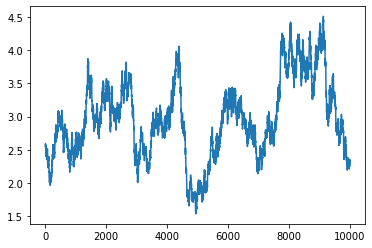

In [8]:
r = SimCIR(0.5,2.55,0.365,2.55,10000,1/360)
plt.plot(r)